#  HTRU2 Data Set 

`HTRU2` è un dataset che descrive un campione di stelle candidate come _Pulsar_ (una rara tipologia di stelle di neutroni)

Ogni pulsar produce un segnale leggermente differente ad ogni rotazione, per questo un potenziale _'candidato'_ viene mediato su diverse rotazioni

Il _Machine Learning_ ha aiutato molto lo studio di queste particolari stelle in quanto la classificazione veniva fatta a mano

In [2]:
%matplotlib inline
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format

PULS_URL = "https://gitlab.com/emrevoid/uni/dia/project/seintz/-/raw/master/HTRU_2.csv"
response = requests.get(PULS_URL)
file_object = io.StringIO(response.content.decode('utf-8'))
pulsds = pd.read_csv(file_object, header=0, index_col=False, sep=r'\s*,\s*', engine='python')

pulsds.head()

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
0,140.56,55.68,-0.23,-0.70,3.20,19.11,7.98,74.24,0
1,102.51,58.88,0.47,-0.52,1.68,14.86,10.58,127.39,0
2,103.02,39.34,0.32,1.05,3.12,21.74,7.74,63.17,0
3,136.75,57.18,-0.07,-0.64,3.64,20.96,6.90,53.59,0
4,88.73,40.67,0.60,1.12,1.18,11.47,14.27,252.57,0


Ogni candidato viene descritto da 8 variabili continue e una singola classe

1. Mean of the integrated profile
2. Standard deviation of the integrated profile
3. Excess kurtosis of the integrated profile
4. Skewness of the integrated profile
5. Mean of the DM-SNR curve
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve
8. Skewness of the DM-SNR curve
9. Class

La variabile target è `class`, è binaria ed assume valore `1` se la stella in esame è una pulsar altrimenti `0`


In [9]:
pulsds["class"].value_counts()

0    16259
1     1639
Name: class, dtype: int64

In [10]:
pulsds["class"].value_counts(normalize=True)

0   0.91
1   0.09
Name: class, dtype: float64

Come possiamo notare dal dataset i dati in questione sono molto sbilanciati, questo è dovuto al fatto che i raggi emissi dalle pulsar sono molto simili alle interferenze di onde radio presenti nell'universo, motivo per il quale sono difficili da distinguere

In [11]:
pulsds.describe()

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
count,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00
mean,111.08,46.55,0.48,1.77,12.61,26.33,8.30,104.86,0.09
std,25.65,6.84,1.06,6.17,29.47,19.47,4.51,106.51,0.29
min,5.81,24.77,-1.88,-1.79,0.21,7.37,-3.14,-1.98,0.00
25%,100.93,42.38,0.03,-0.19,1.92,14.44,5.78,34.96,0.00
50%,115.08,46.95,0.22,0.20,2.80,18.46,8.43,83.06,0.00
75%,127.09,51.02,0.47,0.93,5.46,28.43,10.70,139.31,0.00
max,192.62,98.78,8.07,68.10,223.39,110.64,34.54,1191.00,1.00


La tabella ci mostra valori utili per la descrizione del dataset

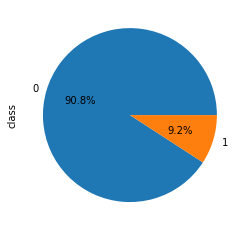

In [12]:
pulsds["class"].value_counts().plot.pie(autopct='%1.1f%%');

Dal grafico a torta possiamo ben notare che il nostro dataset  piuttosto sbilanciato, quindi in fase di analissi andrà fatta una normalizzazione.

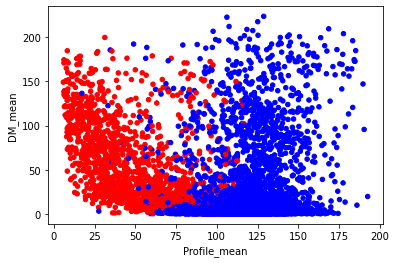

In [13]:
class_map = {0: "blue", 1: "red"}
class_color = pulsds["class"].map(class_map)
pulsds.plot.scatter("Profile_mean", "DM_mean", c=class_color);

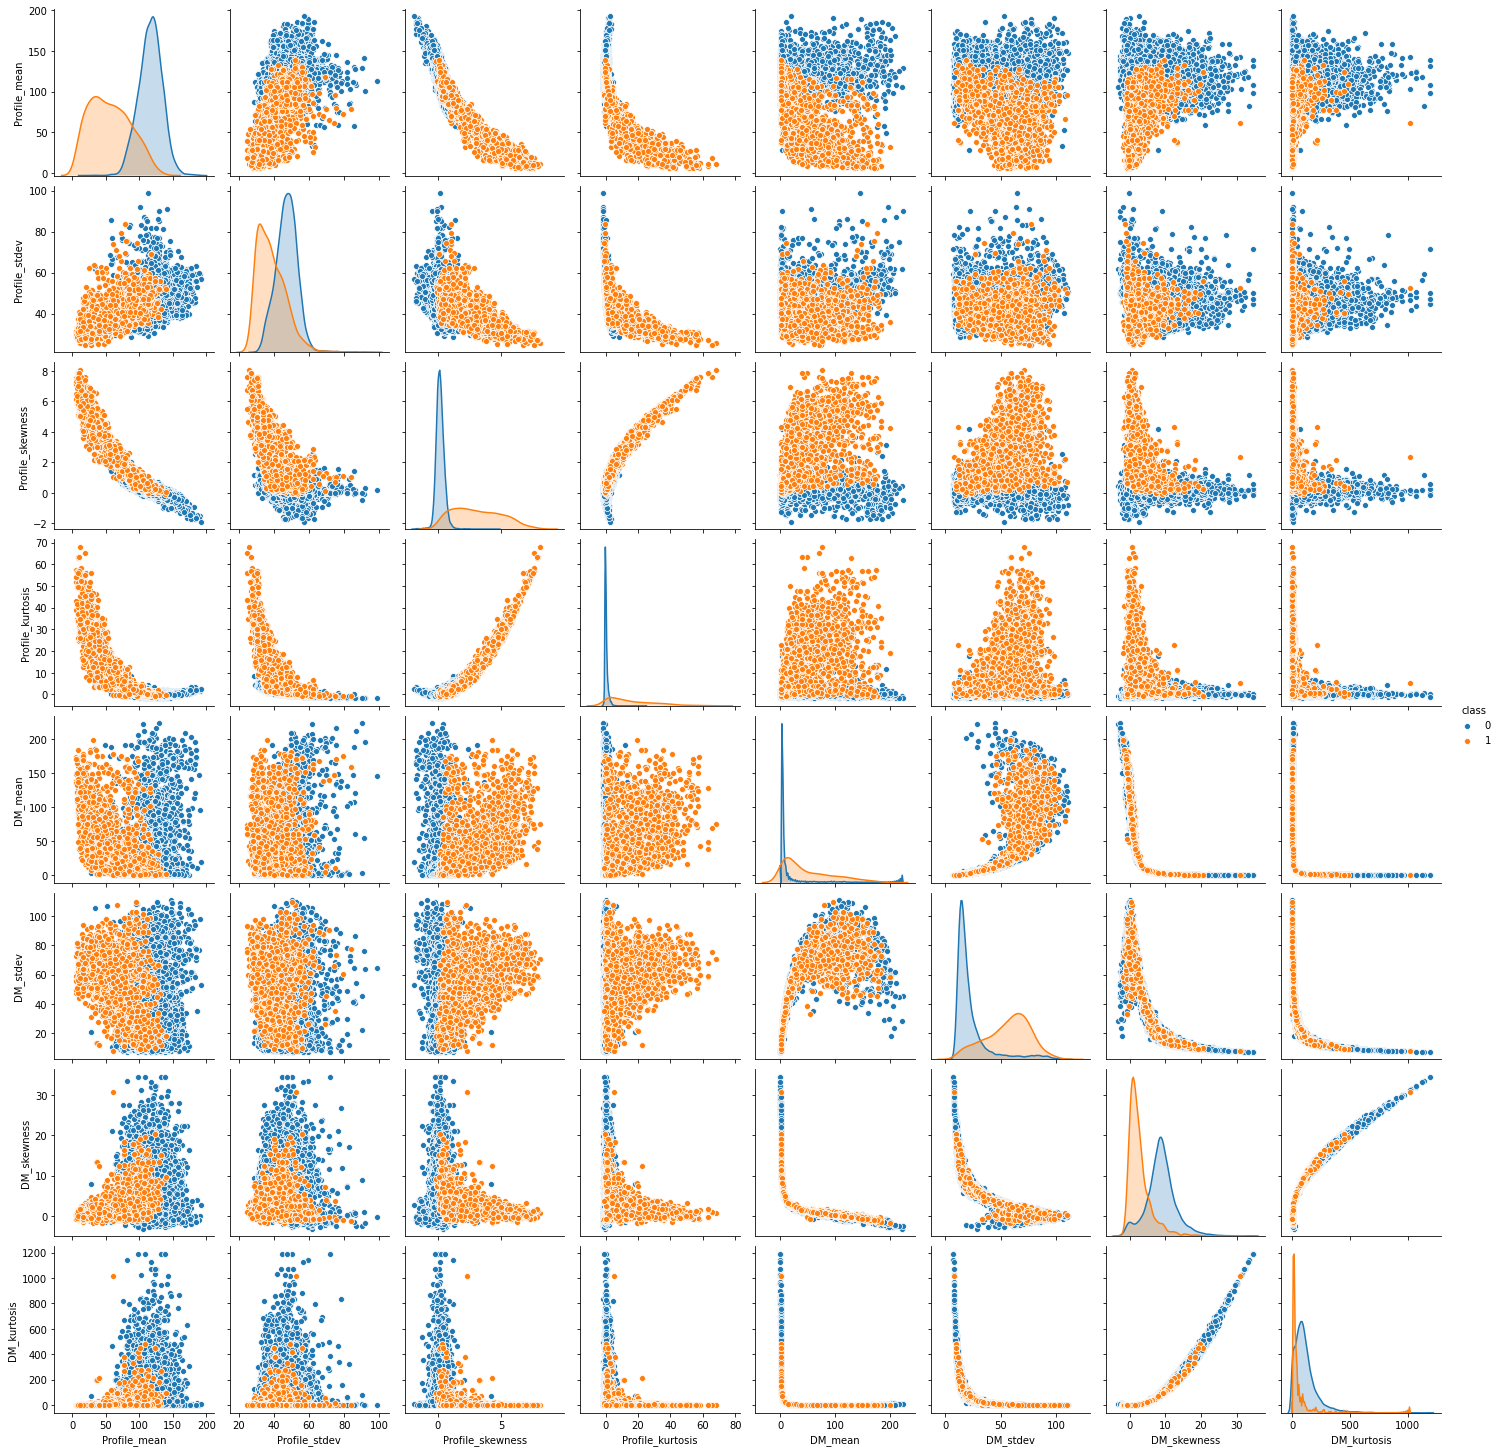

In [14]:
sns.pairplot(data=pulsds, hue="class");

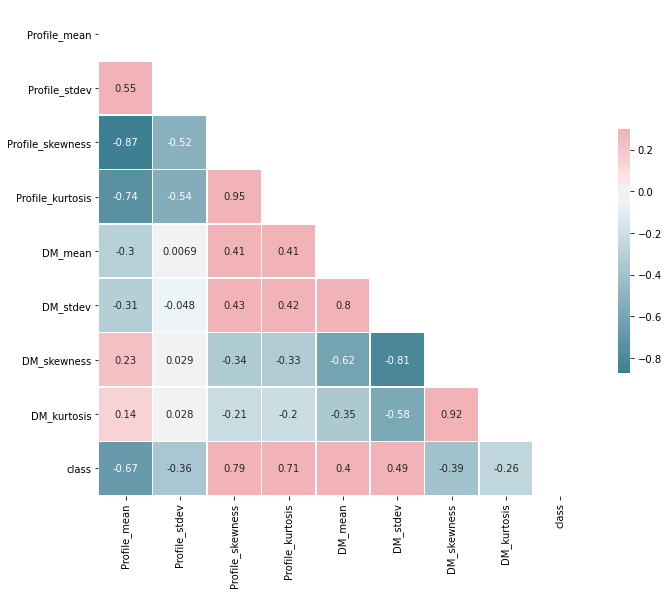

In [15]:
def plot_correlation(dataset):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(dataset, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(dataset, mask=mask, cmap=cmap, vmax=.3, center=0,
                annot = True, square=True, linewidths=.5, cbar_kws={"shrink": .5});
    
    
plot_correlation(pulsds.corr())

Grazie ai grafici sopra riportati abbiamo una visione migliore di come è distribuito il nostro dataset,ci aiuta inoltre ad individuare relazioni tra le variabili, semplificandoci le scelte nel corso dell'analisi

## Preparazione del dataset

### Gestione dei valori nulli

In [16]:
pulsds.isna().sum()

Profile_mean        0
Profile_stdev       0
Profile_skewness    0
Profile_kurtosis    0
DM_mean             0
DM_stdev            0
DM_skewness         0
DM_kurtosis         0
class               0
dtype: int64

Non essendoci valori nulli non abbiamo bisogno di effettuare alcuna operazione su di essi

In [13]:
X = pulsds.drop('class', axis=1)
y = pulsds['class']

In [14]:
pulsds.shape

(17898, 9)

In [15]:
pulsds["class"].value_counts()

0    16259
1     1639
Name: class, dtype: int64

Come già notato prima, il nostro dataset è sbilanciato quindi occorre effettuare delle operazioni di normalizzazione per bilanciarlo, in modo tale da poter analizzare le due casistiche e metterle a confronto

In [16]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

print(sorted(Counter(y_resampled).items()))

[(0, 16259), (1, 16259)]


In [17]:
sns.set();
pulsds_oversampled = pd.concat([X_resampled, y_resampled], axis=1)

In [18]:
pulsds.shape

(17898, 9)

In [19]:
pulsds_oversampled["class"].value_counts()

1    16259
0    16259
Name: class, dtype: int64

In [20]:
pulsds_oversampled["class"].value_counts(normalize=True)

1   0.50
0   0.50
Name: class, dtype: float64

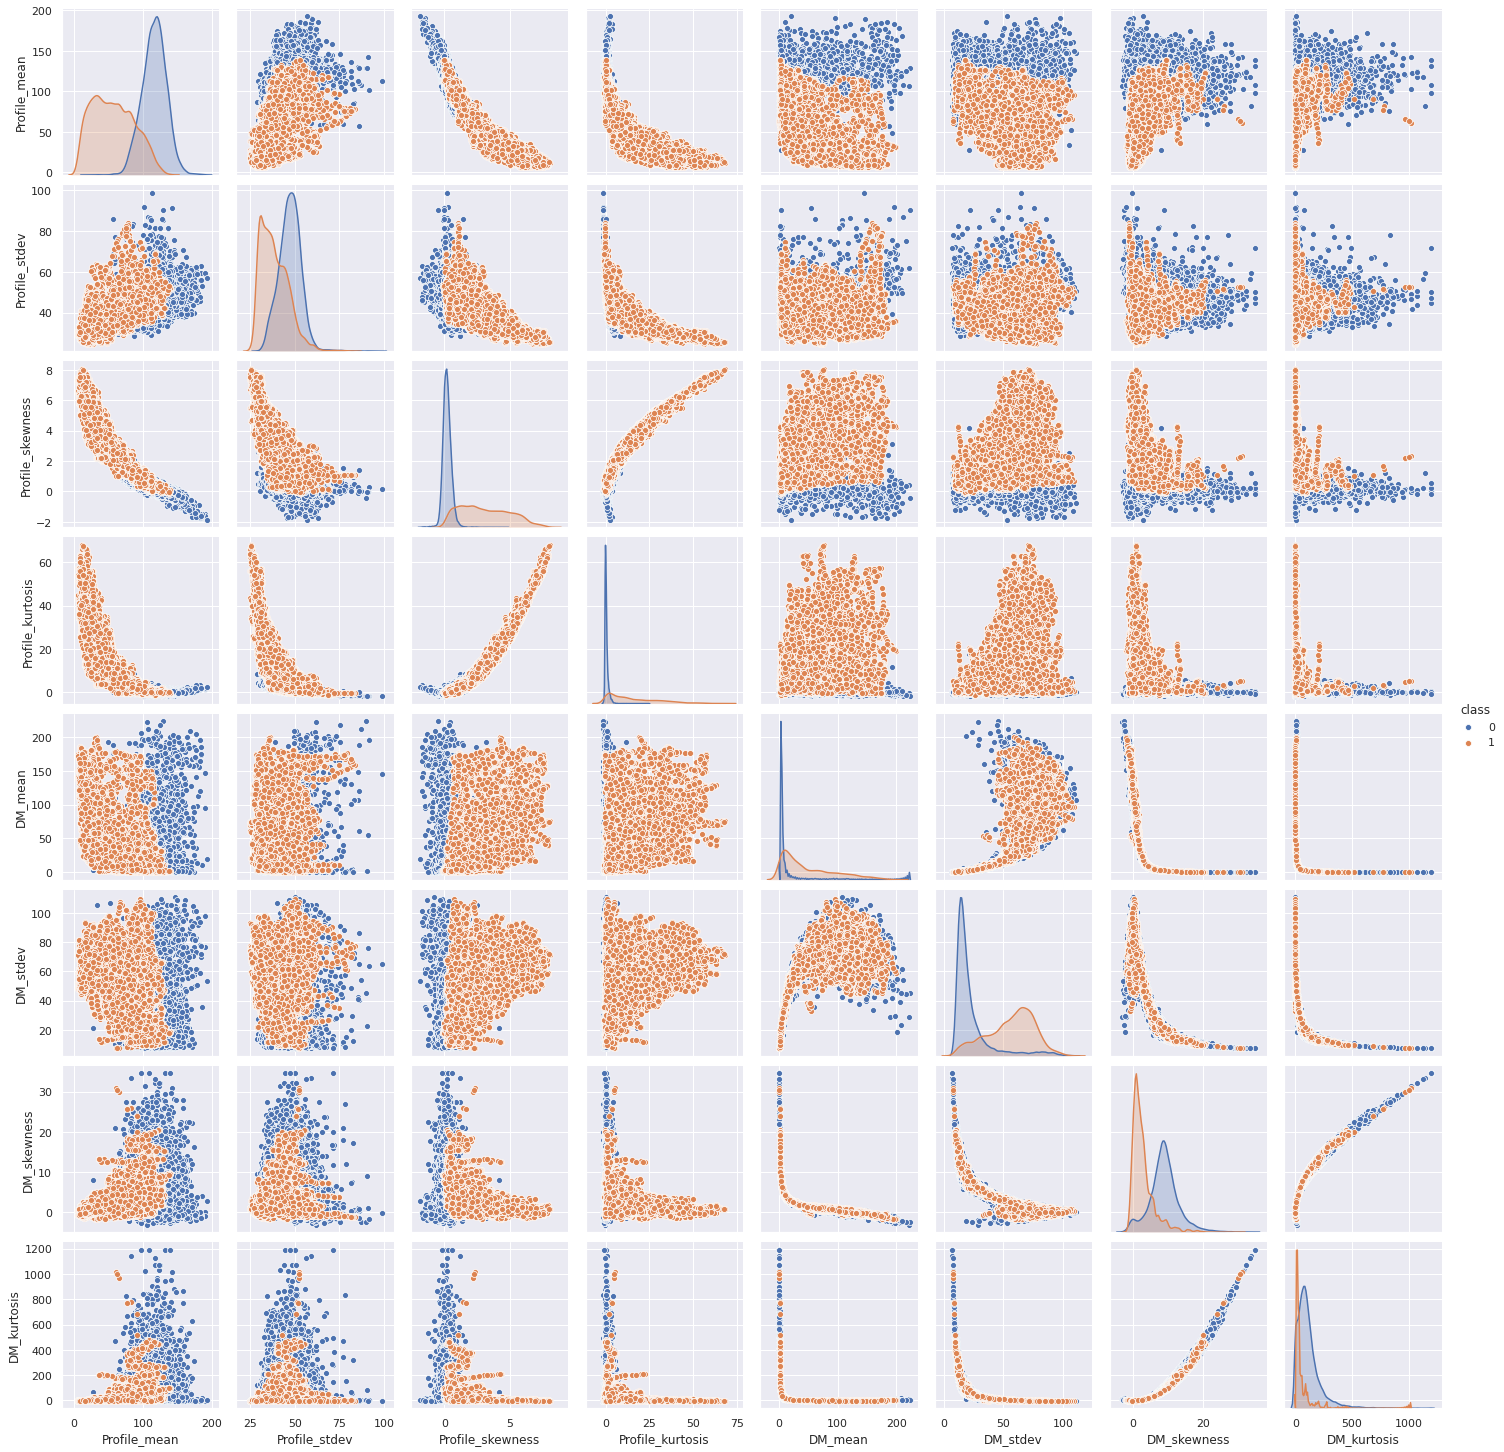

In [21]:
sns.pairplot(data=pulsds_oversampled, hue="class");

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled,
    test_size=1/3,
    random_state=42,
)

In [23]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)

for train, val in skf.split(X_train, y_train):
    print(y_train.iloc[val].value_counts())

1    3619
0    3607
Name: class, dtype: int64
1    3619
0    3607
Name: class, dtype: int64
1    3618
0    3608
Name: class, dtype: int64


## Perceptron

### balanced

In [65]:
scale = [None, StandardScaler()]
polynomial = [PolynomialFeatures(include_bias=False)]
grid = [
    {
        "std" : scale,
        "perceptron__penalty": ["l2", "l1", "elasticnet"],
        "perceptron__alpha": np.logspace(-2, 2, 5)
    },
]

# Perceptron with standard scaler
model_perceptron = Pipeline([
    ('std', None),
    ('perceptron', Perceptron(random_state=42))
])

gs = GridSearchCV(model_perceptron, grid, cv=skf)
gs.fit(X_train, y_train)

print('Accuracy on train {:.2f}%'.format(gs.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs.score(X_val, y_val)*100))
print(gs.best_params_)

Accuracy on train 91.11%
Accuracy on val 90.65%
{'perceptron__alpha': 0.01, 'perceptron__penalty': 'l1', 'std': StandardScaler()}


### unbalanced

In [25]:
X_train_unb, X_val_unb, y_train_unb, y_val_unb = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42,
)

In [66]:
# Perceptron with standard scaler
model_perceptron_unb = Pipeline([
    ('std', None),
    ('perceptron', Perceptron(random_state=42))
])

gs_unb = GridSearchCV(model_perceptron_unb, grid, cv=skf)
gs_unb.fit(X_train_unb, y_train_unb);

print('Accuracy on train {:.2f}%'.format(gs_unb.score(X_train_unb, y_train_unb)*100))
print('Accuracy on val {:.2f}%'.format(gs_unb.score(X_val_unb, y_val_unb)*100))
print(gs_unb.best_params_)

Accuracy on train 96.77%
Accuracy on val 96.83%
{'perceptron__alpha': 0.01, 'perceptron__penalty': 'l2', 'std': StandardScaler()}


## confusion matrix

In [27]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


### balanced

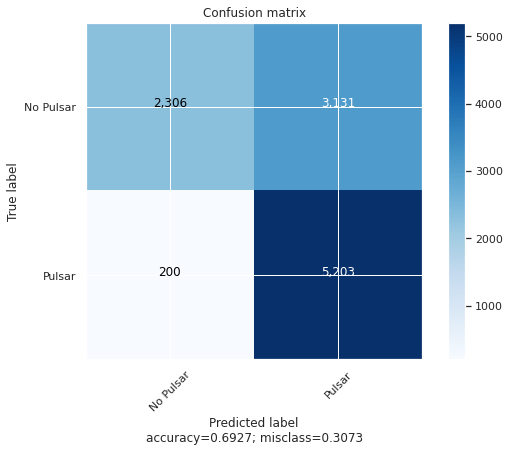

In [28]:
y_pred = gs.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(cm, target_names=['No Pulsar', 'Pulsar'], normalize=False)

### unbalanced

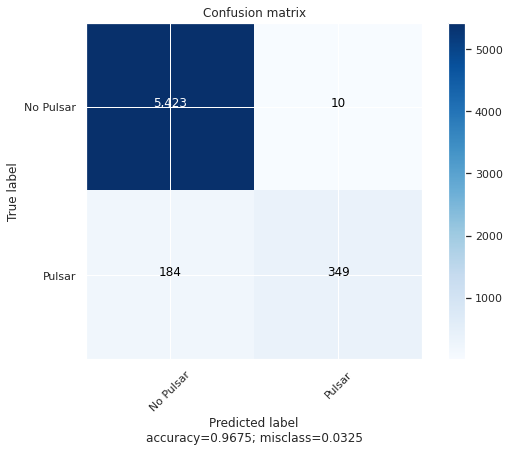

In [29]:
y_pred_unb = gs_unb.predict(X_val_unb)
cm_unb = confusion_matrix(y_val_unb, y_pred_unb)
plot_confusion_matrix(cm_unb, target_names=['No Pulsar', 'Pulsar'], normalize=False)

## precison & recall

### balanced

In [30]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.42      0.58      5437
           1       0.62      0.96      0.76      5403

    accuracy                           0.69     10840
   macro avg       0.77      0.69      0.67     10840
weighted avg       0.77      0.69      0.67     10840



### unbalanced

In [31]:
print(classification_report(y_val_unb, y_pred_unb))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5433
           1       0.97      0.65      0.78       533

    accuracy                           0.97      5966
   macro avg       0.97      0.83      0.88      5966
weighted avg       0.97      0.97      0.96      5966



## regressione logistica

In [32]:
scale = [None, StandardScaler()]
grid = [
    {
        "std" : scale,
        "logreg__penalty": ["l1"],
        "logreg__C": np.logspace(-2, 2, 5)
    },
]

# Perceptron with standard scaler
model_logreg = Pipeline([
    ('std', None),
    ('logreg', LogisticRegression(solver="saga", dual=False, random_state=42, max_iter=10000))
])

gs_logreg = GridSearchCV(model_logreg, grid, cv=skf)
gs_logreg.fit(X_train, y_train)

print('Accuracy on train {:.2f}%'.format(gs_logreg.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs_logreg.score(X_val, y_val)*100))
print(gs_logreg.best_params_)

Accuracy on train 94.28%
Accuracy on val 94.23%
{'logreg__C': 10.0, 'logreg__penalty': 'l1', 'std': StandardScaler()}


In [34]:
y_pred_logreg = gs_logreg.predict(X_val)
print(classification_report(y_val, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5437
           1       0.97      0.91      0.94      5403

    accuracy                           0.94     10840
   macro avg       0.94      0.94      0.94     10840
weighted avg       0.94      0.94      0.94     10840



## SVM 

In [35]:
scale = [None, StandardScaler()]
grid = [
    {
        "std" : scale,
        "svm__C": np.logspace(-3, 3, 3)
    },
]

# Perceptron with standard scaler
model_svm = Pipeline([
    ('std', None),
    ('svm', SVC())
])

gs_svm = GridSearchCV(model_svm, grid, cv=skf)
gs_svm.fit(X_train, y_train)

print('Accuracy on train {:.2f}%'.format(gs_svm.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs_svm.score(X_val, y_val)*100))
print(gs_svm.best_params_)

Accuracy on train 95.70%
Accuracy on val 95.13%
{'std': StandardScaler(), 'svm__C': 1000.0}


In [36]:
y_pred_svm = gs_svm.predict(X_val)
print(classification_report(y_val, y_pred_svm))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5437
           1       0.98      0.92      0.95      5403

    accuracy                           0.95     10840
   macro avg       0.95      0.95      0.95     10840
weighted avg       0.95      0.95      0.95     10840



## confronto

In [44]:
def diff_interval(a1, a2, N1, N2, Z):
    sigma1 = a1 * (1 - a1) / N1
    sigma2 = a2 * (1 - a2) / N2
    sigma = np.sqrt(sigma1 + sigma2)
    diff = abs(a1 - a2)
    Z_sigma = Z * sigma
    return (diff - Z_sigma, diff + Z_sigma)


def model_diff_interval(m1, m2, X, y, level=0.95):
    from scipy.stats import norm
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N1 = len(X)
    N2 = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N1, N2, Z)

In [47]:
model_diff_interval(gs, gs_unb, X_val, y_val)

(0.11758830424027598, 0.14016077325049892)

In [53]:
model_diff_interval(gs, gs_logreg, X_val, y_val)

(0.2399002257070319, 0.2593617669128943)

In [54]:
model_diff_interval(gs, gs_svm, X_val, y_val)

(0.2489952815679829, 0.2681633900187329)

In [55]:
model_diff_interval(gs_logreg, gs_svm, X_val, y_val)

(0.0029755085576295493, 0.014921170409160044)